In [ ]:
pip install emoji

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Import functions for data preprocessing
import re
import emoji
import string
from string import punctuation
import nltk
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# pre trained model for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer


from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/ds-project/youtube_multi_videos_comments.csv')
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,author,text,video_id,public
0,0,@ImOskar835,Ayo What's poping Logang What's up Logan Yes Sir,XpVt6Z1Gjjo,True
1,1,@rivvs3372,why am i here,XpVt6Z1Gjjo,True
2,2,@ermaroedel3058,You told Kong to be jealous he’s part of the r...,XpVt6Z1Gjjo,True
3,3,@austinkingpellew,I can't believe I'm rewatching Logan videos th...,XpVt6Z1Gjjo,True
4,4,@franciscod822,Asked Eid eekd Jesus have a good day or someth...,XpVt6Z1Gjjo,True
...,...,...,...,...,...
163802,163802,@tatiannawasrobbed1614,LOVE,pCSgWJzEvrM,True
163803,163803,@rinksronks,"I love you and your videos Anna, I hope you're...",pCSgWJzEvrM,True
163804,163804,@keilawn3840,2nd,pCSgWJzEvrM,True
163805,163805,@jorgemiranda5652,First,pCSgWJzEvrM,True


In [ ]:
data=data.drop(['Unnamed: 0','author','video_id','public'],axis=1)
data

,text
0,Ayo What's poping Logang What's up Logan Yes Sir
1,why am i here
2,You told Kong to be jealous he’s part of the r...
3,I can't believe I'm rewatching Logan videos th...
4,Asked Eid eekd Jesus have a good day or someth...
...,...
163802,LOVE
163803,"I love you and your videos Anna, I hope you're..."
163804,2nd
163805,First


In [ ]:
data.isnull().sum()

text    5
dtype: int64

In [ ]:
data.dropna(subset=['text'], inplace=True)
data.isnull().sum()

text    0
dtype: int64

In [ ]:
def comment_text_processing(text):

    # Remove URL links
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)
    # remove new line characters in text
    text = re.sub(r'\n',' ', text)
    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)
    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # remove special characters from text
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove emojis from the text
    text = emoji.demojize(text)
     # convert text into lowercase
    text = text.lower()
    # Tokenization
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    processed_text = ' '.join(words)

    return processed_text

In [ ]:
# Apply preprocessing to the comment text
data.text = data.text.apply(lambda text: comment_text_processing(text))

In [ ]:
# using pretrained model for sentiment analysis
SIA = SentimentIntensityAnalyzer()
data["Positive"] = [SIA.polarity_scores(i)["pos"] for i in data["text"]]
data["Negative"] = [SIA.polarity_scores(i)["neg"] for i in data["text"]]
data["Neutral"] = [SIA.polarity_scores(i)["neu"] for i in data["text"]]
data['Compound'] = [SIA.polarity_scores(i)["compound"] for i in data["text"]]
score = data["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data["Sentiment"] = sentiment
data.head()

,text,Positive,Negative,Neutral,Compound,Sentiment
0,ayo what pope logang what logan ye sir,0.000,0.000,1.000,0.0000,Neutral
1,,0.000,0.000,0.000,0.0000,Neutral
2,told kong jealou part reason got offens congra...,0.205,0.000,0.795,0.4767,Positive
3,cant believ im rewatch logan video day rip mav...,0.000,0.127,0.873,-0.1531,Negative
4,ask eid eekd jesu good day someth keep week,0.266,0.000,0.734,0.4404,Positive


In [10]:
data.dropna(subset=['text'], inplace=True)
data.isnull().sum()

text         0
Positive     0
Negative     0
Neutral      0
Compound     0
Sentiment    0
dtype: int64

In [11]:
data=data.drop(['Positive','Negative','Neutral','Compound'],axis=1)
data.head()

,text,Sentiment
0,ayo what pope logang what logan ye sir,Neutral
1,,Neutral
2,told kong jealou part reason got offens congra...,Positive
3,cant believ im rewatch logan video day rip mav...,Negative
4,ask eid eekd jesu good day someth keep week,Positive


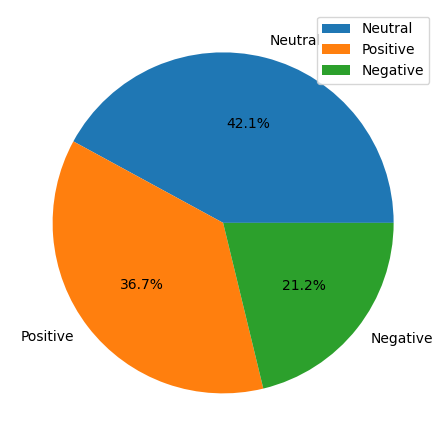

In [12]:
plt.figure(figsize=(5.5,7.5))
plt.pie(data['Sentiment'].value_counts(),autopct="%1.1f%%",labels=data['Sentiment'].value_counts().index)
plt.legend(loc='best')
plt.show()

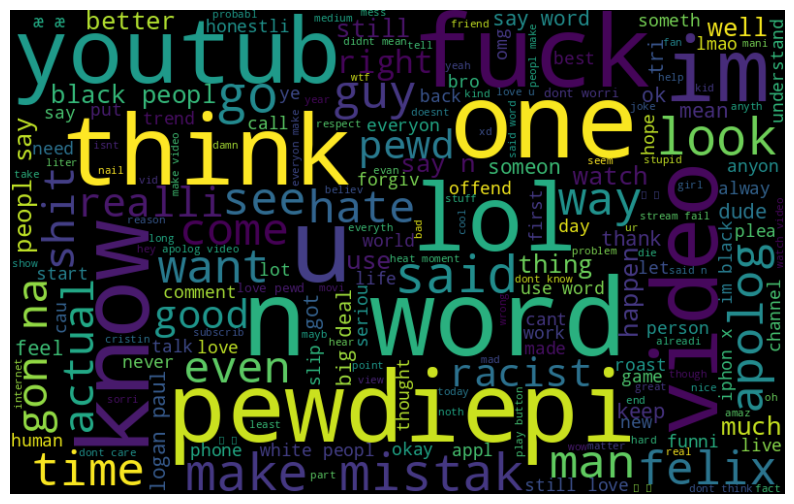

In [ ]:
all_words = ' '.join([text for text in data['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


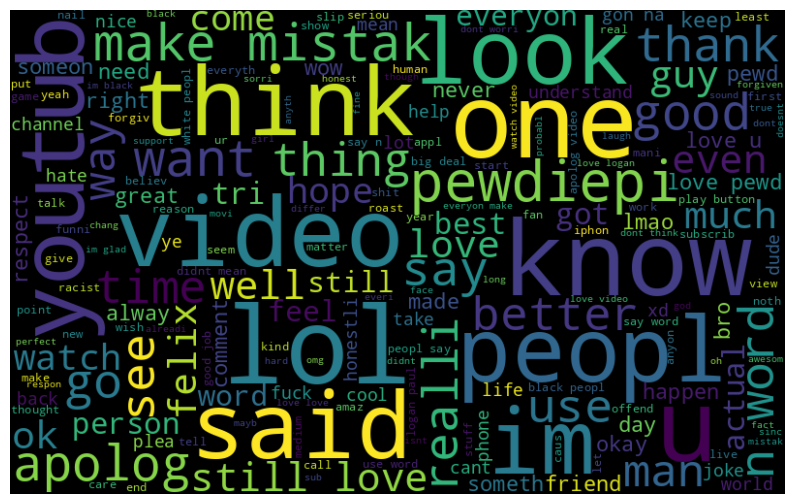

In [ ]:
data_positive = data[data['Sentiment'] == 'Positive']
all_words_positive = ' '.join(data_positive['text'].str.lower())

# all_words_positive = ' '.join([text for text in data['text'][data['Sentiment'] == 'Positive']])
wordcloud_positive = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_positive)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis('off')
plt.show()

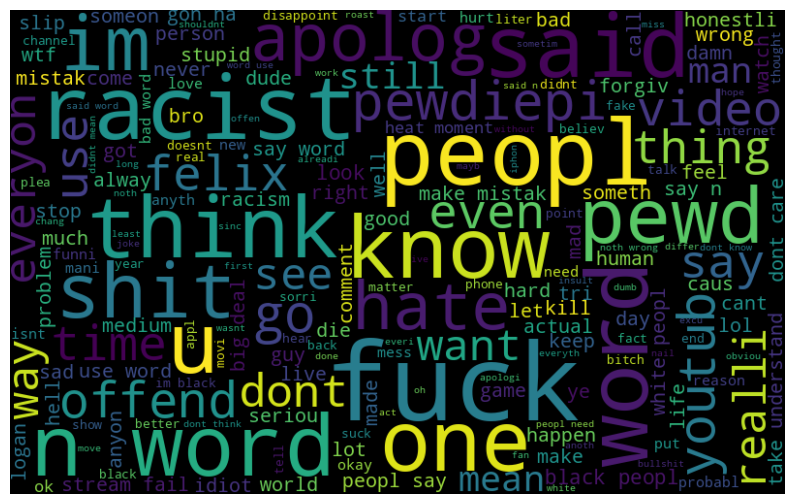

In [ ]:
data_negative = data[data['Sentiment'] == 'Negative']
all_words_negative = ' '.join(data_negative['text'].str.lower())
wordcloud_negative = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_negative)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis('off')
plt.show()

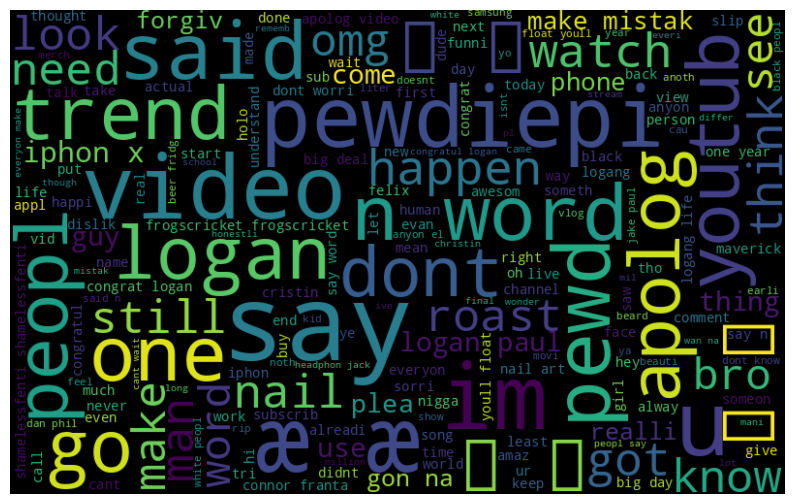

In [ ]:
all_words_neutral = ' '.join([text for text in data['text'][data.Sentiment == 'Neutral']])
wordcloud_neutral = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_neutral)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis('off')
plt.show()

In [89]:
# convert categorical data to numerical
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])
processed_data = {
    'text':data.text,
    'Sentiment':data['Sentiment']
}

processed_data = pd.DataFrame(processed_data)
processed_data.head()

,text,Sentiment
0,ayo what pope logang what logan ye sir,1
1,,1
2,told kong jealou part reason got offens congra...,2
3,cant believ im rewatch logan video day rip mav...,0
4,ask eid eekd jesu good day someth keep week,2


In [90]:
processed_data['Sentiment'].value_counts()

1    68911
2    60146
0    34745
Name: Sentiment, dtype: int64

In [91]:
# df_neutral = processed_data[(processed_data['Sentiment']==1)]
# df_negative = processed_data[(processed_data['Sentiment']==0)]
# df_positive = processed_data[(processed_data['Sentiment']==2)]

# # upsample minority classes
# df_negative_upsampled = resample(df_negative,
#                                  replace=True,
#                                  n_samples= 68911,
#                                  random_state=55)

# df_positive_upsampled = resample(df_positive,
#                                  replace=True,
#                                  n_samples= 68911,
#                                  random_state=55)

# # Concatenate the upsampled dataframes with the neutral dataframe
# final_data = pd.concat([df_negative_upsampled,df_positive_upsampled,df_neutral])
# final_data['Sentiment'].value_counts()

0    68911
2    68911
1    68911
Name: Sentiment, dtype: int64

In [112]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    processed_data['text'],
    processed_data['Sentiment'],
    test_size=0.2,
    random_state=55
)
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features based on your data size
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [113]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

classifier = LinearSVC()
classifier.fit(X_train_tfidf.toarray(), y_train)
y_predict = classifier.predict(X_test_tfidf)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_predict)
print(f"Model Accuracy: {accuracy.round(3)*100}%")

# Display additional metrics
print('\nClassification Report:')
print(classification_report(y_test, y_predict))


Model Accuracy: 91.0%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      6976
           1       0.93      0.98      0.96     13749
           2       0.91      0.89      0.90     12036

    accuracy                           0.91     32761
   macro avg       0.90      0.89      0.90     32761
weighted avg       0.91      0.91      0.91     32761



In [114]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[ 5601,   493,   882],
       [  132, 13454,   163],
       [  793,   479, 10764]])

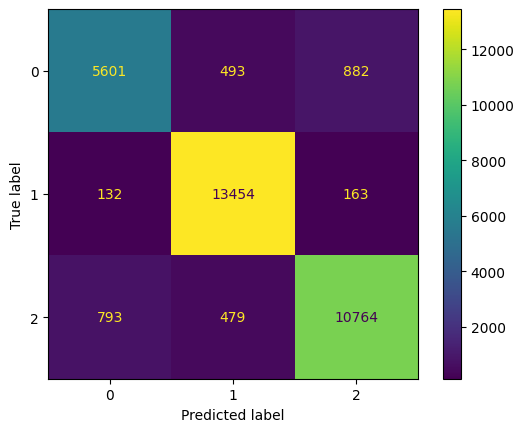

In [115]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

In [136]:
def predict_sentiment(user_input, vectorizer, classifier):
    # Preprocess user input if needed (e.g., lowercase, removing stop words)
    # You can use the same preprocessing steps applied during training

    # Vectorize the user input using the TF-IDF vectorizer
    user_input_tfidf = vectorizer.transform([user_input])

    # Predict sentiment using the trained classifier
    prediction = classifier.predict(user_input_tfidf)

    return prediction[0]

# Example Usage:
user_text = input("Enter the text: ")
predicted_sentiment = predict_sentiment(user_text, tfidf_vectorizer, classifier)
ps = {0:'Negative',1:'Neutral',2:'Positive'}
print(f"Predicted Sentiment: {ps[predicted_sentiment]}")

Enter the text: Good conceptual video. I was your 1k'th like
Predicted Sentiment: Positive


In [139]:
import joblib

# Save the TF-IDF vectorizer and classifier
joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/ds-project/tfidf_vectorizer.joblib')
joblib.dump(classifier, '/content/drive/MyDrive/ds-project/sentiment_classifier.joblib')

# Load the TF-IDF vectorizer and classifier
loaded_tfidf_vectorizer = joblib.load('/content/drive/MyDrive/ds-project/tfidf_vectorizer.joblib')
loaded_classifier = joblib.load('/content/drive/MyDrive/ds-project/sentiment_classifier.joblib')

# Example usage for prediction with the loaded model
user_text = "I really enjoyed the movie, it was fantastic!"
user_input_tfidf = loaded_tfidf_vectorizer.transform([user_text])
predicted_sentiment = loaded_classifier.predict(user_input_tfidf)

print(f"Predicted Sentiment: {predicted_sentiment[0]}")

Predicted Sentiment: 1
